In [71]:
# General
import pandas as pd
import numpy as np
import re
import networkx as nx
import itertools
import collections
import spacy
from pprint import pprint

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import bigrams
from nltk.stem import PorterStemmer

from collections import Counter
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set(font_scale=1.5)
sns.set_style("whitegrid")
%matplotlib inline

In [19]:
df = pd.read_csv('twcs.csv')
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [20]:
df['text'] = df['text'].apply(str)

In [21]:
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
df.shape

(2782618, 7)

In [26]:
count = df['text'].str.split().str.len()

In [27]:
print("Total number of words:", count.sum(), "words")
print("Mean number of words per tweet:", round(count.mean(),2), "words")

Total number of words: 54571833 words
Mean number of words per tweet: 19.61 words


In [29]:
df["tweet_length"] = df["text"].str.len()
print("Total length of the dataset is:", df.tweet_length.sum(), "characters")

Total length of the dataset is: 319256663 characters


In [30]:
print("Mean Length of a tweet is:", round(df.tweet_length.mean(),0), "characters")
df = df.drop(['tweet_length'], axis=1)

Mean Length of a tweet is: 115.0 characters


In [41]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

def remove_links(tweet):
    return re.sub(r"http\S+", "", tweet)

In [33]:
df['tidy_tweet'] = np.vectorize(remove_users)(df['text'], "@ [\w]*", "@[\w]*")
df['tidy_tweet'] = df['tidy_tweet'].str.lower()
df['hashtags'] = df['tidy_tweet'].apply(lambda twt : re.findall(r"# (\w+)", twt))

In [34]:
d = Counter(df.hashtags.sum())
df_hashtags = pd.DataFrame([d]).T

In [35]:
df_hashtags.columns = ['freq']
df_hashtags.freq.sum()

14269

In [36]:
df_hashtags.sort_values(by=['freq'], ascending=False, inplace=True)
df_hashtags.head(20)

,freq
and,1822
so,1816
to,1792
or,1602
for,643
associated,488
in,425
on,380
via,257
is,217


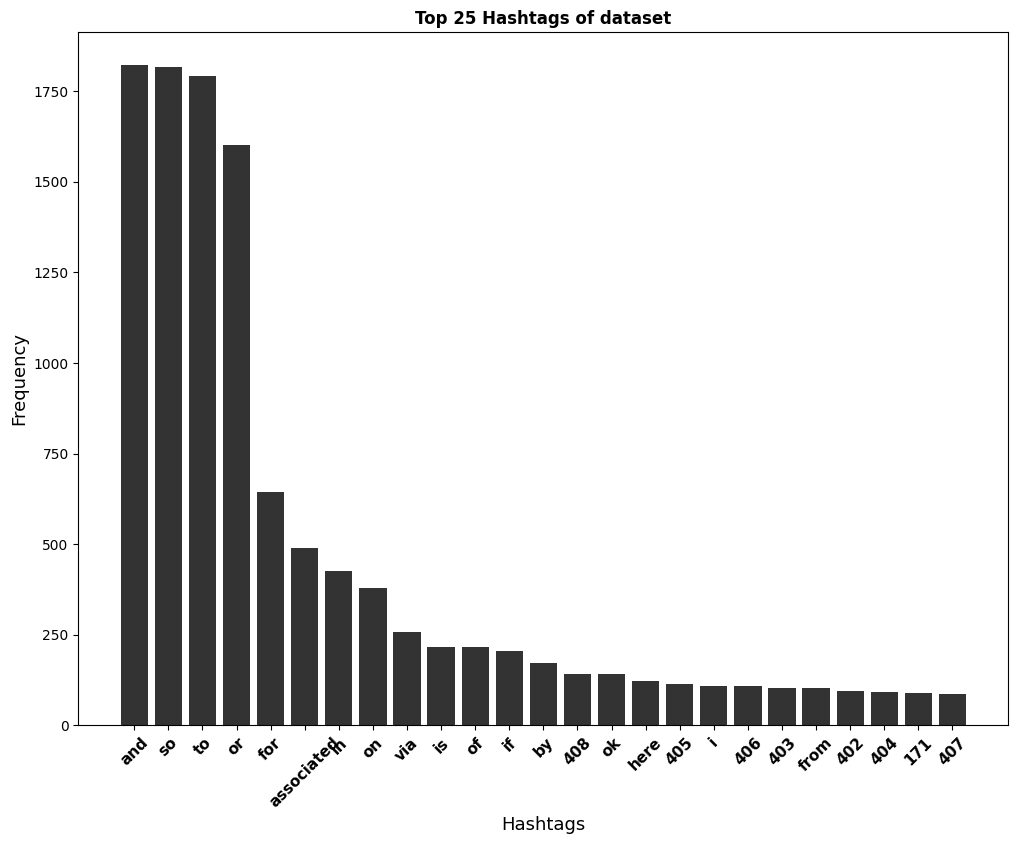

In [38]:
# Visualization of Top 25 Hashtags
labels = df_hashtags.head(25).index.values.tolist()
freq = df_hashtags['freq'].head(25).values.tolist()
index = np.arange(len(freq))

plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Hashtags', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, labels, fontsize=11, rotation=45, fontweight="bold") 
plt.title('Top 25 Hashtags of dataset', fontsize=12, fontweight="bold")
plt.show()

In [39]:
df = df.drop(['hashtags'], axis=1)

In [42]:
df['tidy_tweet'] = np.vectorize(remove_users)(df['tidy_tweet'], "# [\w]*", "#[\w]*")
df['tidy_tweet'] = np.vectorize(remove_links)(df['tidy_tweet'])
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\2432915983.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")


In [45]:
def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True)) 

def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]
        
df['tidy_tweet_tokens'] = list(tokenize(df['tidy_tweet']))
stop_words = stopwords.words('english')
df['tokens_no_stop'] = remove_stopwords(df['tidy_tweet_tokens'])

In [46]:
df['length'] = df['tokens_no_stop'].apply(len)
df = df.drop(df[df['length']<3].index)
df = df.drop(['length'], axis=1)
df.shape

(2480323, 10)

In [47]:
df.reset_index(drop=True, inplace=True)

In [48]:
# Join the tweet back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    return (" ".join(words))

df['no_stop_joined'] = df.apply(rejoin_words, axis=1)
all_words = ' '.join(list(df['no_stop_joined']))

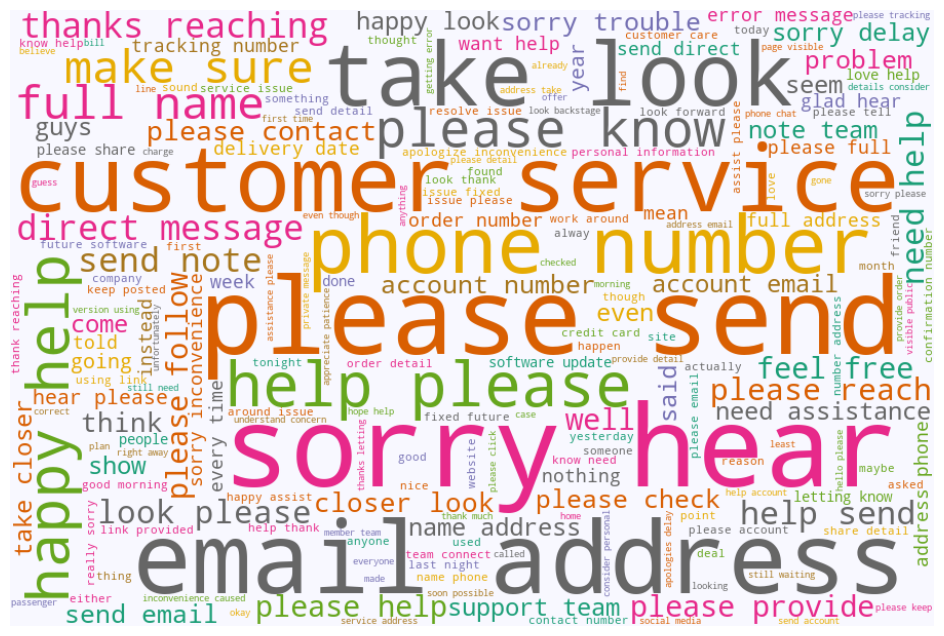

In [49]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='Dark2').generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [51]:
df["tweet_length"] = df["text"].str.len()
df["cleaned_tweet_length"] = df["no_stop_joined"].str.len()
df_lengths = df[['tweet_length', 'cleaned_tweet_length']]

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\1795582314.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, color="black", label="No. Words", bins=35, hist_kws={"alpha": 0.5,"rwidth":0.8})
C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\1795582314.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

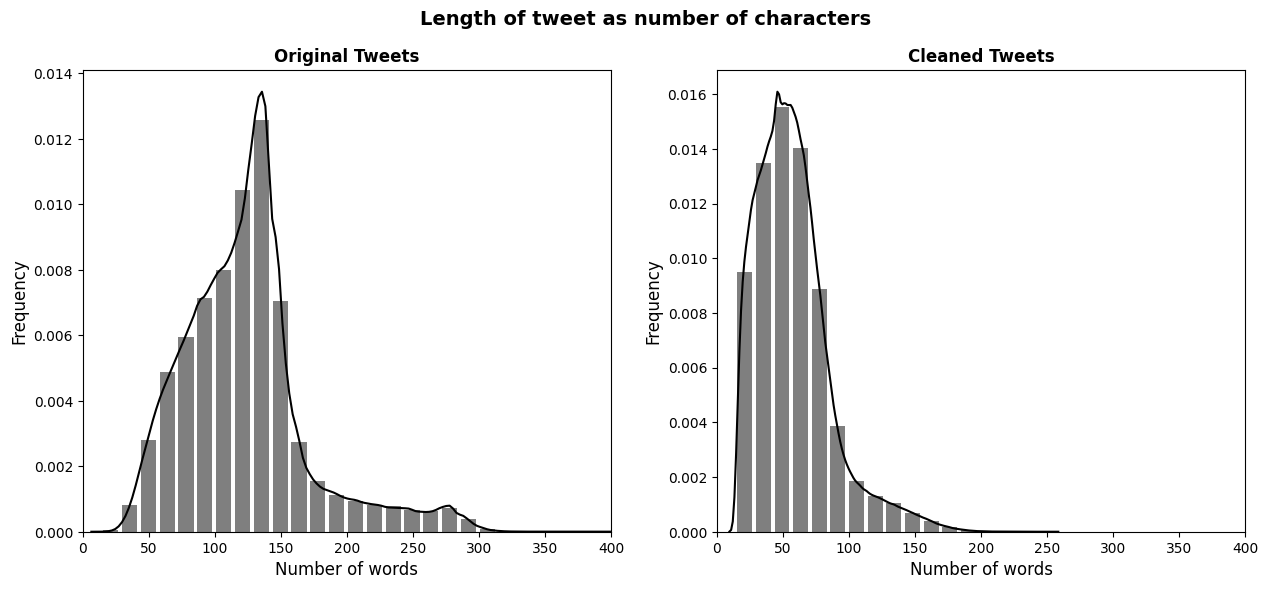

In [52]:
x1 = df_lengths.tweet_length
x2 = df_lengths.cleaned_tweet_length
plt.figure(figsize=(15,6))
plt.suptitle('Length of tweet as number of characters', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x1, color="black", label="No. Words", bins=35, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="black", label="No. Words", bins=17, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

plt.show()

In [54]:
df["tweet_words"] = df['text'].str.split().str.len()
df["cleaned_tweet_words"] = df["no_stop_joined"].str.split().str.len()
df_lengths = df[['tweet_words', 'cleaned_tweet_words']]

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\4142016048.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_1, color="black", label="No. Words", bins=25, hist_kws={"alpha": 0.5,"rwidth":0.8})
C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\4142016048.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



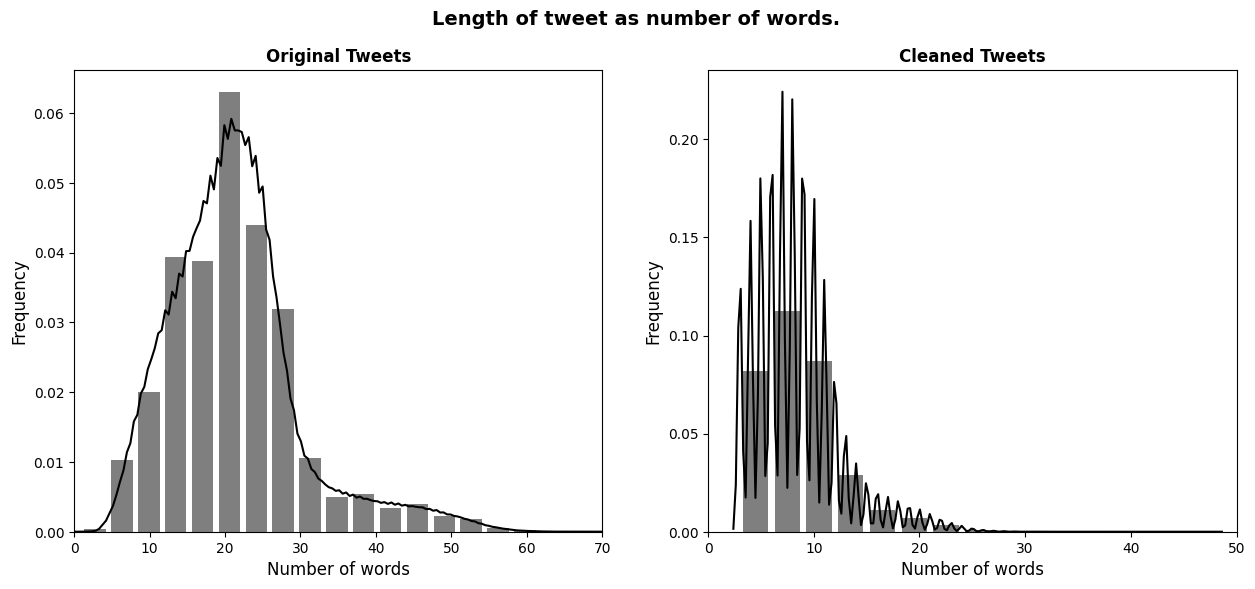

In [55]:
x_1 = df_lengths.tweet_words
x_2 = df_lengths.cleaned_tweet_words
plt.figure(figsize=(15,6))
plt.suptitle('Length of tweet as number of words.', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x_1, color="black", label="No. Words", bins=25, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,70])



# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x_2, color="black", label="No. Words", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,50])

plt.show()

In [56]:
df = df.drop(['tweet_length', 'cleaned_tweet_length', 'tweet_words', 'cleaned_tweet_words'], axis=1)
word_freq = pd.Series(np.concatenate([x.split() for x in df.no_stop_joined])).value_counts()

In [58]:
word_df = pd.Series.to_frame(word_freq)
word_df['word'] = list(word_df.index)
word_df.reset_index(drop=True, inplace=True)
word_df.columns = ['freq', 'word']

Unique words: 188575


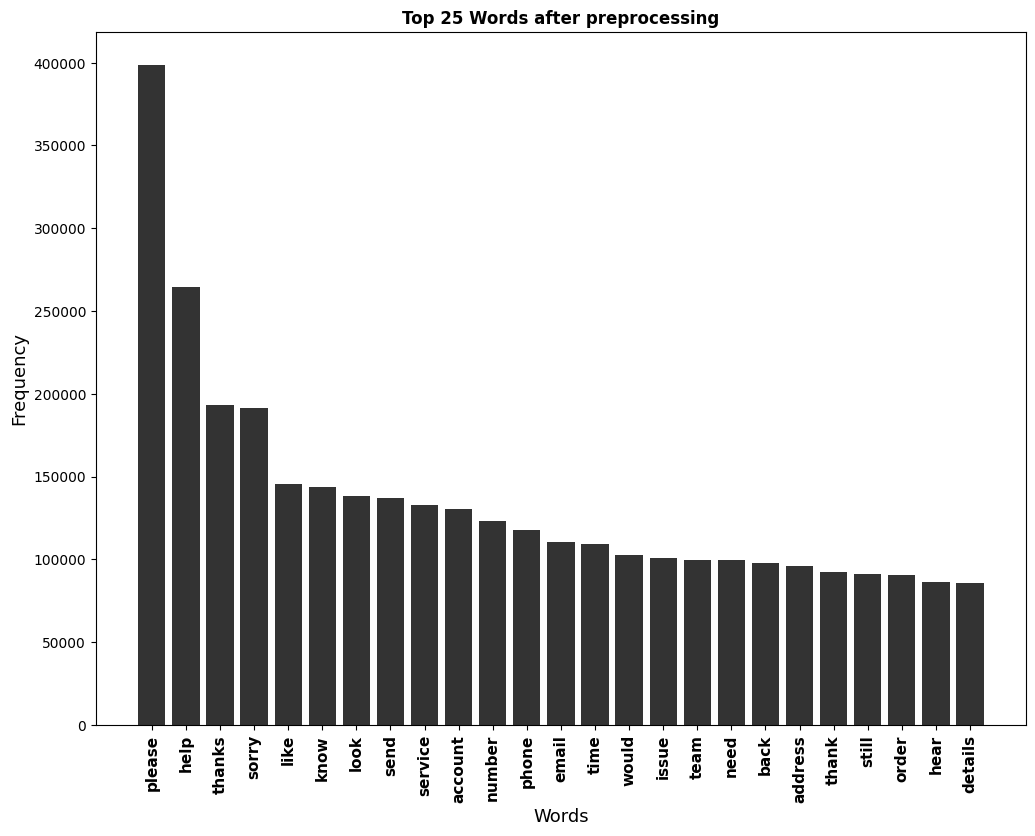

In [59]:
label = word_df['word'].head(25)
freq = word_df['freq'].head(25)
index = np.arange(len(freq))

print("Unique words:", len(word_df))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

In [60]:
df.to_csv('Cleaned_text.csv',index=False)

In [72]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
terms_bigram[0]

[('understand', 'would'),
 ('would', 'like'),
 ('like', 'assist'),
 ('assist', 'would'),
 ('would', 'need'),
 ('need', 'private'),
 ('private', 'secured'),
 ('secured', 'link'),
 ('link', 'assist')]

In [73]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

In [74]:
bigram_df = pd.DataFrame(bigram_counts.most_common(25), columns=['bigram', 'count'])
len(bigram_counts)

4450890

In [75]:
bigram_df.head(25)

,bigram,count
0,"(sorry, hear)",53405
1,"(please, send)",47151
2,"(email, address)",40940
3,"(customer, service)",32030
4,"(take, look)",30959
5,"(phone, number)",29234
6,"(help, please)",24355
7,"(happy, help)",23177
8,"(would, like)",22565
9,"(please, know)",22018


Number of Bigrams Identified 25


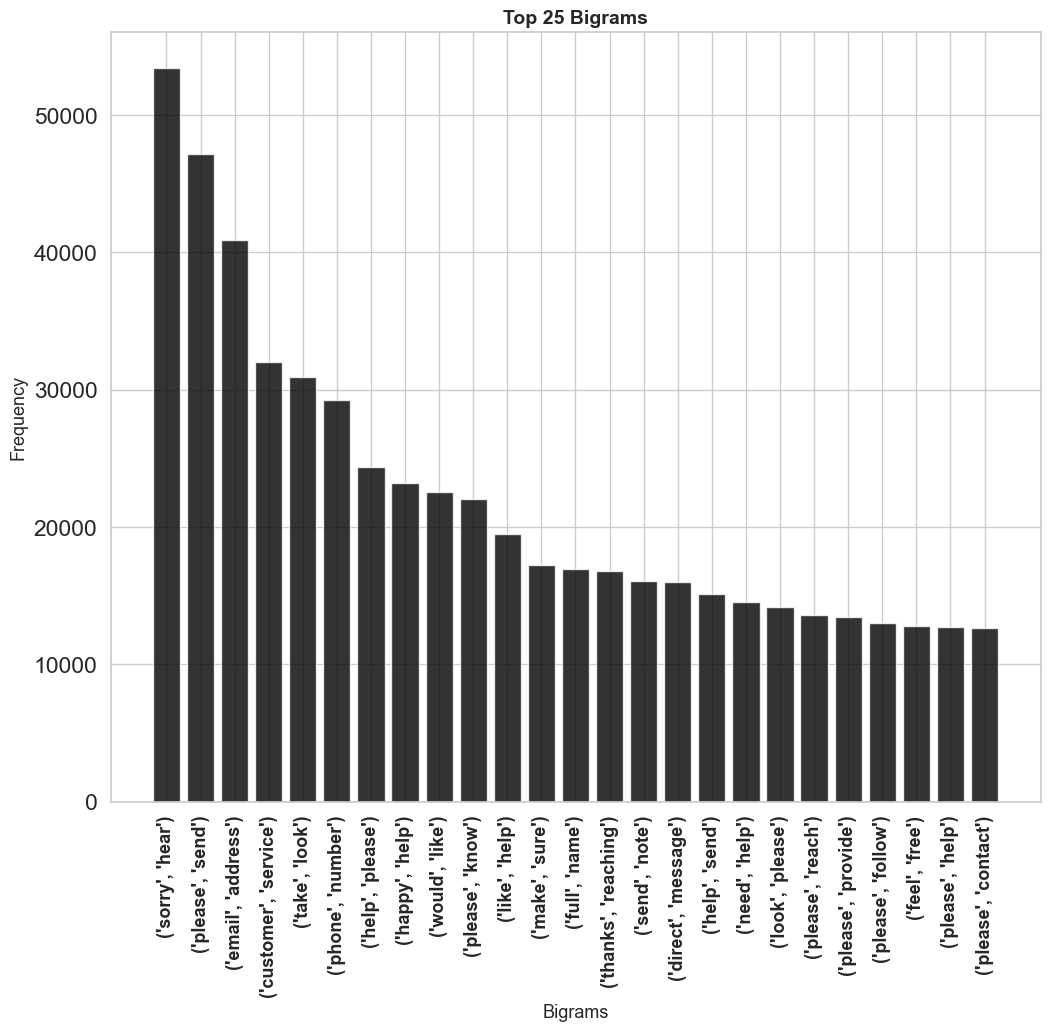

In [78]:
bigram_freq = bigram_df['count'].head(25)
index = np.arange(len(bigram_freq))

print("Number of Bigrams Identified", len(bigram_df))
plt.figure(figsize=(12,10))
plt.bar(index, bigram_freq, alpha=0.8, color= 'black')
plt.xlabel('Bigrams', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, bigram_df['bigram'].values, fontsize=13, rotation=90, fontweight="bold") 
plt.title('Top 25 Bigrams', fontsize=14, fontweight="bold")
plt.show()

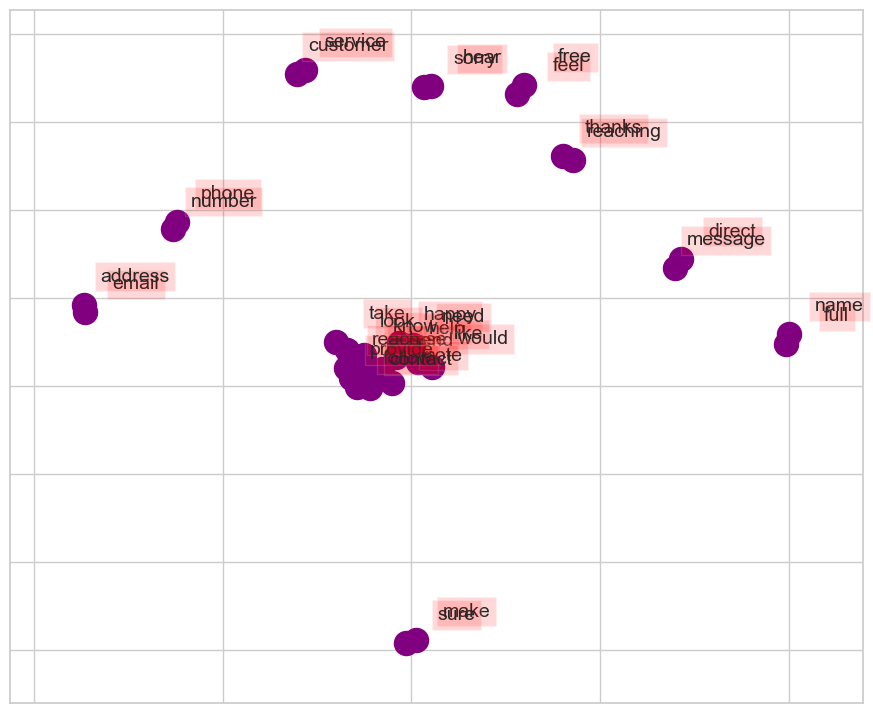

In [79]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.15),
            horizontalalignment='center', fontsize=14)
    
plt.show()

In [81]:
data = df.no_stop_joined.values.tolist()
print(data[:1])

['understand would like assist would need private secured link assist']


In [82]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))
print(data_words[:1])

[['understand', 'would', 'like', 'assist', 'would', 'need', 'private', 'secured', 'link', 'assist']]


In [83]:
# Build the bigram and trigram model
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

In [86]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [112]:
df = df.drop(['tidy_tweet','tidy_tweet_tokens','no_stop_joined'], axis=1)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480323 entries, 0 to 2480322
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
 7   tokens_no_stop           object 
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 134.8+ MB


In [114]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,tokens_no_stop
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,"[understand, would, like, assist, would, need,..."
1,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,"[sent, several, private, messages, responding,..."
2,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,"[please, send, private, message, assist, click..."
3,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0,"[please, send, private, message, gain, details..."
4,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,"[worst, customer, service]"


In [115]:
def remove_links(tweet):
    return re.sub(r"http\S+", "", tweet)

In [117]:
df['text_p'] = np.vectorize(remove_links)(df['text'])

In [118]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [120]:
df['text_p'] = np.vectorize(remove_users)(df['text_p'], "@ [\w]*", "@[\w]*")

In [121]:
def remove_hashtags(tweet, pattern1):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [122]:
df['text_p'] = np.vectorize(remove_hashtags)(df['text_p'], "#")

In [123]:
def remove_word(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, "", tweet)
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [124]:
df.drop_duplicates(subset=['text_p'], keep='first', inplace=True)

In [125]:
# Create an object of Vader Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [126]:
negative = []
neutral = []
positive = []
compound = []

In [128]:
def sentiment_scores(df, negative, neutral, positive, compound):
    for i in df['text_p']:
        sentiment_dict = vader_analyzer.polarity_scores(i)
        negative.append(sentiment_dict['neg'])
        neutral.append(sentiment_dict['neu'])
        positive.append(sentiment_dict['pos'])
        compound.append(sentiment_dict['compound'])

In [129]:
# Function calling 
sentiment_scores(df, negative, neutral, positive, compound)

In [130]:
# Prepare columns to add the scores later
df["negative"] = negative
df["neutral"] = neutral
df["positive"] = positive
df["compound"] = compound

In [131]:
# Fill the overall sentiment with encoding:
# (-1)Negative, (0)Neutral, (1)Positive
sentiment = []
for i in df['compound']:
    if i >= 0.05 : 
        sentiment.append(1)
  
    elif i <= - 0.05 : 
        sentiment.append(-1) 
        
    else : 
        sentiment.append(0)
df['sentiment'] = sentiment

In [132]:
neg_tweets = df.sentiment.value_counts()[-1]
neu_tweets = df.sentiment.value_counts()[0]
pos_tweets = df.sentiment.value_counts()[1]

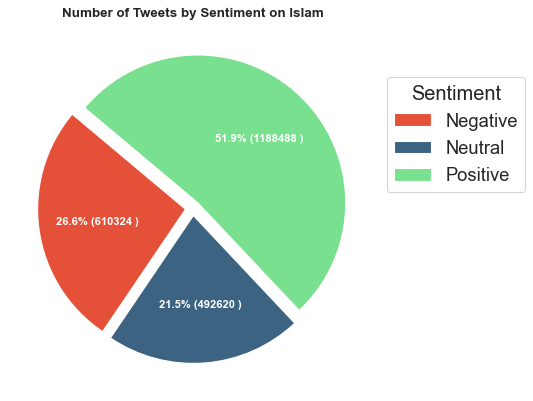

In [133]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
plt.show()

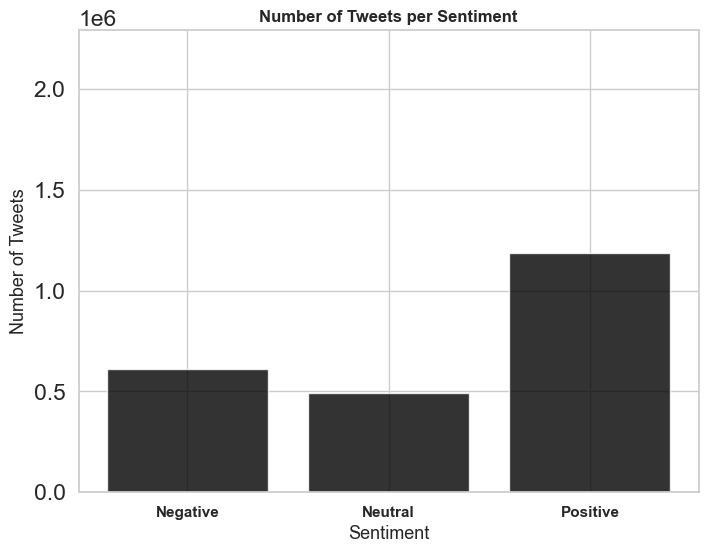

In [136]:
labels = ['Negative', 'Neutral', 'Positive']
freq = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
index = np.arange(len(freq))

plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, labels, fontsize=11, fontweight="bold") 
plt.title('Number of Tweets per Sentiment', fontsize=12, fontweight="bold")
plt.ylim(0, len(df['text_p']))
plt.show()

In [137]:
# We remove the neutral compound scores to compare the negative and positive tweets
data = df[(df["sentiment"]!=0)]

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\747977632.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)


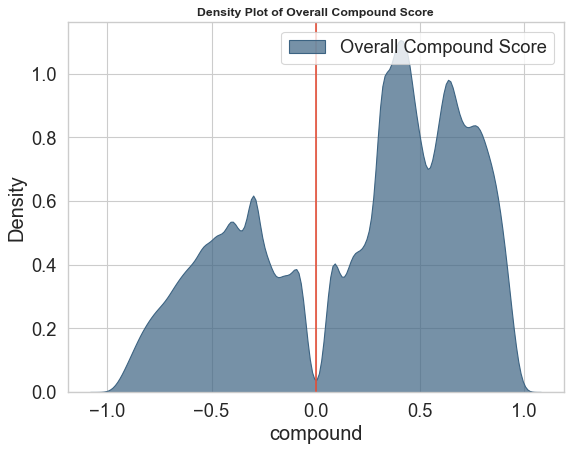

In [138]:
# Draw Plot
plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)

# Decoration
plt.title('Density Plot of Overall Compound Score', fontsize=11, fontweight='bold')
plt.axvline(x=0, color='#e55039')
plt.legend()
plt.show()

### Word Cloud of Positive and Negative Tweets 

In [144]:
df_pos = df[df['sentiment']==1]
df_neg = df[df['sentiment']==(-1)]

### Word Frequency

In [145]:
# Join the tweet back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    return (" ".join(words))

In [146]:
df_neg['no_stop_joined'] = df_neg.apply(rejoin_words, axis=1)

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\511598356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['no_stop_joined'] = df_neg.apply(rejoin_words, axis=1)


In [147]:
word_freq = pd.Series(np.concatenate([x.split() for x in df_neg.no_stop_joined])).value_counts()

In [148]:
word_df = pd.Series.to_frame(word_freq)
word_df['word'] = list(word_df.index)
word_df.reset_index(drop=True, inplace=True)
word_df.columns = ['freq', 'word']

In [149]:
word_df.drop([ 0, 1], inplace=True)

Unique words: 95297


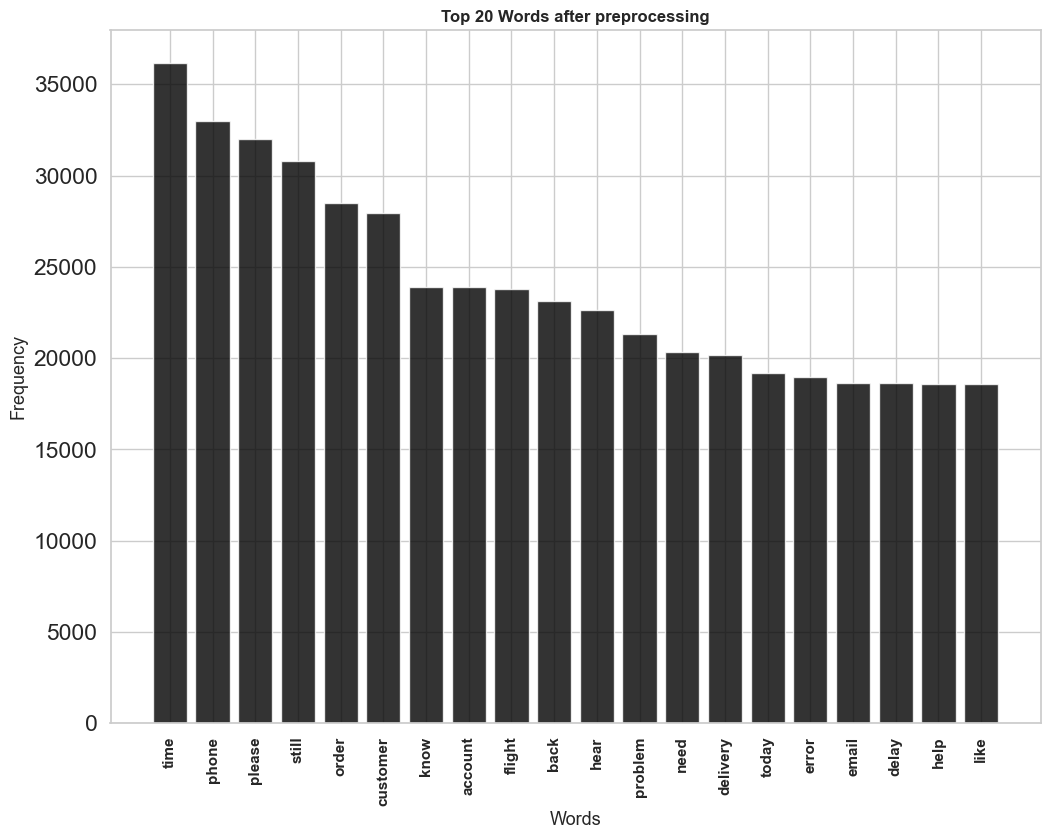

In [150]:
label = word_df['word'].head(20)
freq = word_df['freq'].head(20)
index = np.arange(len(freq))

print("Unique words:", len(word_df))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 20 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

### Positive Tweets

In [151]:
df_pos['no_stop_joined'] = df_pos.apply(rejoin_words, axis=1)

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\2907587920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['no_stop_joined'] = df_pos.apply(rejoin_words, axis=1)


In [152]:
word_freq_pos = pd.Series(np.concatenate([x.split() for x in df_pos.no_stop_joined])).value_counts()

In [153]:
word_df_pos = pd.Series.to_frame(word_freq_pos)
word_df_pos['word'] = list(word_df_pos.index)
word_df_pos.reset_index(drop=True, inplace=True)
word_df_pos.columns = ['freq', 'word']

In [154]:
word_df_pos.drop([0,2], inplace=True)

Unique words: 110954


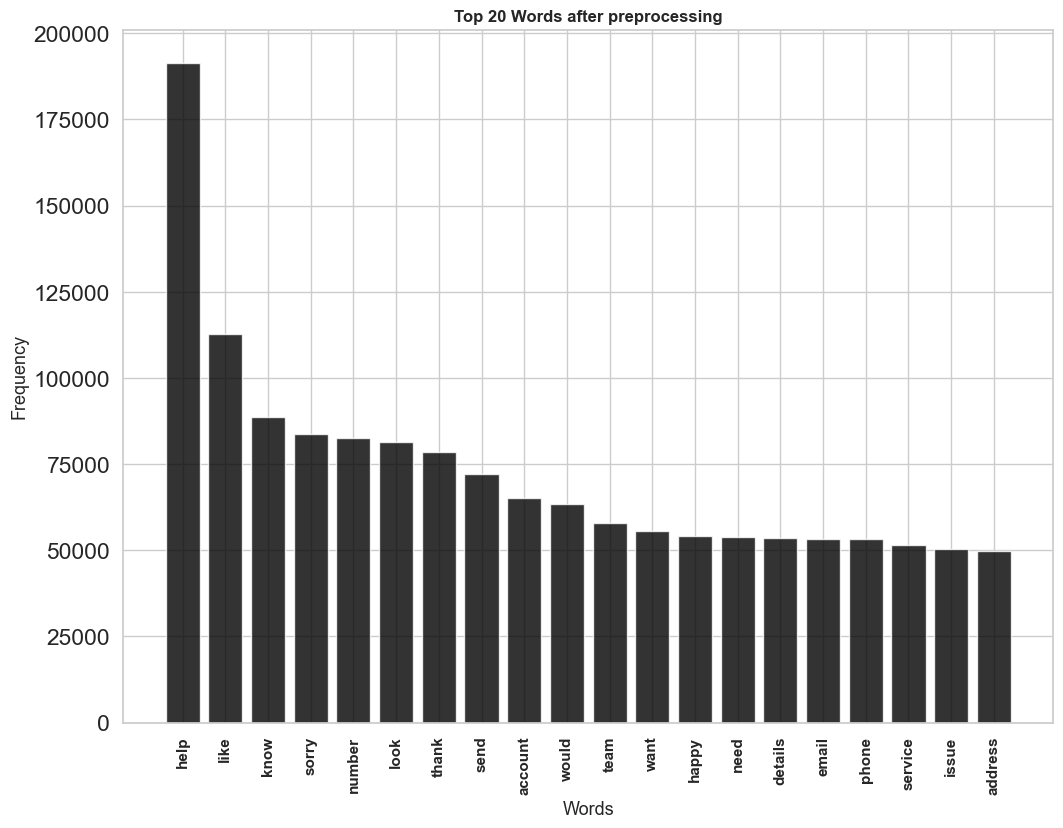

In [155]:
label = word_df_pos['word'].head(20)
freq = word_df_pos['freq'].head(20)
index = np.arange(len(freq))

print("Unique words:", len(word_df_pos))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 20 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

### WordCloud 

In [156]:
all_words_pos = ' '.join(list(df_pos.apply(rejoin_words, axis=1)))
all_words_neg = ' '.join(list(df_neg.apply(rejoin_words, axis=1)))

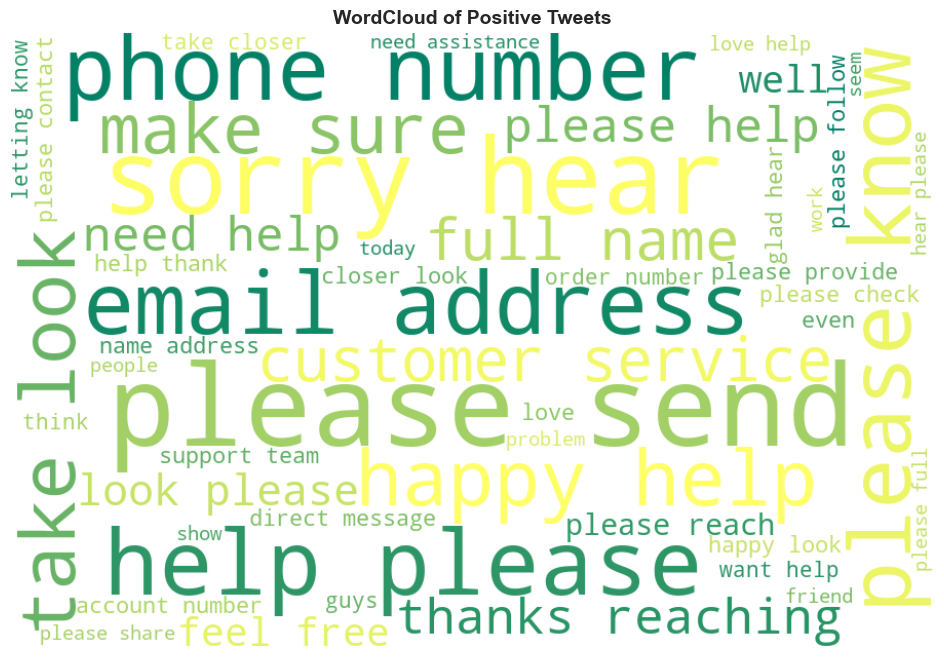

In [157]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

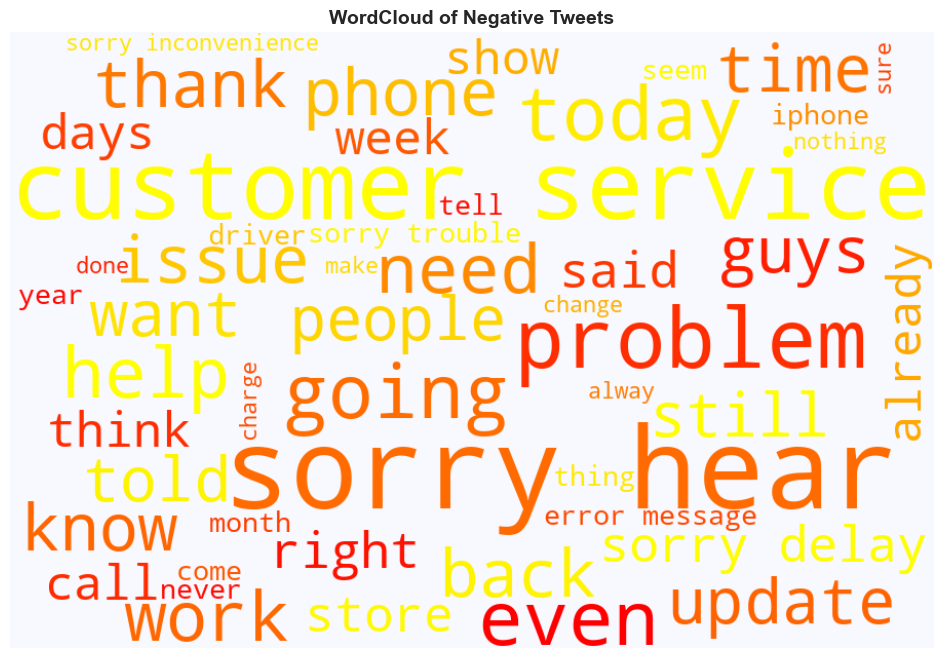

In [158]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=50,colormap='autumn').generate(all_words_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Compound Score Distribution 

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\1621257750.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, color="g", bins=12, hist_kws={"alpha": 0.5,"rwidth":0.8})
C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\1621257750.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2, color

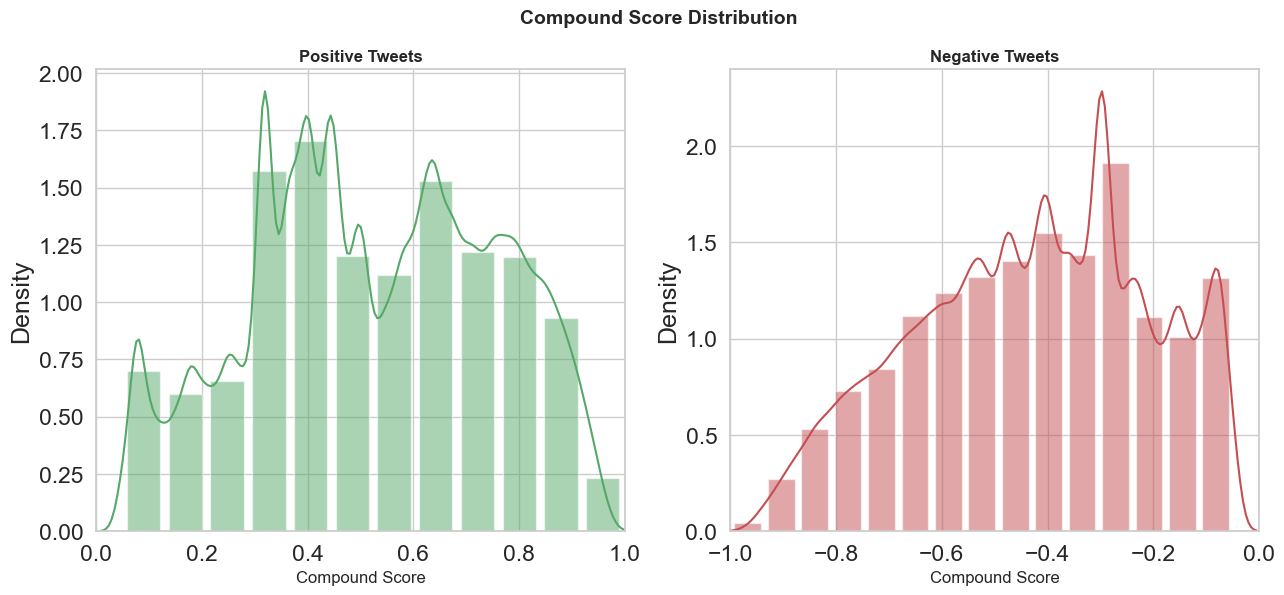

In [159]:
x1 = df_pos['compound']
x2 = df_neg['compound']
plt.figure(figsize=(15,6))
plt.suptitle('Compound Score Distribution', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)

sns.distplot(x1, color="g", bins=12, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title('Positive Tweets',fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([0,1])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="r", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Negative Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([-1,0])

plt.show()

### 10 Most Positive and Negative Tweets

In [163]:
# 10 Most positive Tweets
df_pos.sort_values('compound', inplace=True, ascending=False)
df_pos.reset_index(drop=True, inplace=True)

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\2308027815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos.sort_values('compound', inplace=True, ascending=False)


In [165]:
# 10 Most Negative Tweets
df_neg.sort_values('compound', inplace=True)
df_neg.reset_index(drop=True, inplace=True)

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\1780004765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.sort_values('compound', inplace=True)


#### Save Results as a Dataframe

In [169]:
df.to_pickle('sentiment_analysis_vader_results.pkl')

In [173]:
df_sentiment = df_pos.append(df_neg,ignore_index=True)
df = df[df["sentiment"]==0][['text','sentiment']]
df_sentiment = df_sentiment[['text','sentiment']]
df_sentiment = df_sentiment.append(df,ignore_index=True)
df_sentiment['sentiment'] = df_sentiment['sentiment'].map({0:'neutral',1:'positive',-1:'negative'})

C:\Users\SARIM\AppData\Local\Temp\ipykernel_3292\1380243319.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sentiment = df_pos.append(df_neg,ignore_index=True)


In [191]:
df_sentiment.to_csv('Labeled_data.csv',index=False)